In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

import sys
sys.path.append('/project/dissertation')

# Load custom modules
from utils.config import config as cf
import utils.feature_eng_utils as feature_utils
from utils import ml_models
from utils import neural_network_model as nn_model
import warnings
warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


In [2]:
# Load training data
df = pd.read_csv(cf.DATA_PATH+'/train.csv', parse_dates=['Date'])
df['Description'] = df['Description'].fillna('')

df = feature_utils.preprocess_description(df, True)
# df.head()

======= Load Currency :::  /project/dissertation/resources/currency.csv
Total  285  rows
======= Load Cities name :::  /project/dissertation/resources/nz_cities.csv
Total  1040  rows
======= Load Stopword name :::  /project/dissertation/resources/stop_words.csv
Total  10  rows


In [3]:
# Load text embeddings and merge with numeric features
fasttext_embeddings = np.load(cf.EXPORT_PATH+'/text_embeddings/FastText.npy')
desc_embedding = pd.DataFrame(fasttext_embeddings)
X = pd.concat([desc_embedding,  df[['isExpense', 'isAcctNo', 'isOverseas']]], axis=1)

# Encode label 
lb_make = LabelEncoder()
y = lb_make.fit_transform(df['label'])
y= to_categorical(np.asarray(y))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,isExpense,isAcctNo,isOverseas
0,0.017959,-0.013190,0.014538,-0.018996,0.048453,-0.000470,-0.007357,-0.064340,-0.003274,0.028703,...,0.002667,0.010593,-0.047581,-0.063368,-0.001983,-0.020694,-0.034144,1,0,0
1,-0.032586,0.013775,0.019253,-0.055363,-0.094376,-0.039773,-0.007985,-0.124254,0.025856,0.009919,...,0.025153,-0.022944,-0.026166,0.012058,-0.005366,-0.027929,-0.046564,1,0,0
2,-0.019716,-0.068639,-0.001862,0.024958,-0.046710,-0.060750,0.012915,-0.089007,0.026206,-0.002590,...,-0.025809,-0.009938,0.006084,0.022432,0.027588,-0.009896,-0.008567,1,0,0
3,0.002800,-0.005657,0.041282,-0.067148,-0.060220,-0.032235,-0.036372,-0.105444,-0.013942,0.059444,...,0.002112,-0.007724,0.009107,0.001799,-0.002830,-0.053920,-0.026631,1,0,0
4,-0.001916,-0.024082,0.014094,-0.001462,-0.026449,-0.019436,-0.022096,-0.102912,0.004760,-0.047719,...,-0.017592,0.043732,-0.000662,0.009683,0.026104,0.030170,-0.007618,0,0,0


In [4]:
len(df)

12920

--------------------------------------------------------------------------------------------

# Dense Neural Network

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=cf.RANDOM_ST)
print('Train :', len(X_train), ' Test :', len(X_test), ' Total :', len(X_train) + len(X_test))

Train : 10336  Test : 2584  Total : 12920


In [7]:
model = nn_model.initialize_nn_model(X_train.shape[1], y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               77824     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 56)                14392     
Total params: 92,216
Trainable params: 92,216
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file= cf.EXPORT_PATH + 'nn_model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(df['label']), df['label'])
history = model.fit(X_train, y_train, epochs=40, verbose=2, validation_data=(X_test, y_test), batch_size=10, class_weight=class_weights)

W0726 16:18:22.196722 139965615699776 deprecation.py:323] From /opt/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10336 samples, validate on 2584 samples
Epoch 1/40
 - 2s - loss: 1.5157 - acc: 0.6497 - val_loss: 0.9341 - val_acc: 0.7616
Epoch 2/40
 - 2s - loss: 0.7742 - acc: 0.8111 - val_loss: 0.6791 - val_acc: 0.8328
Epoch 3/40
 - 2s - loss: 0.5889 - acc: 0.8536 - val_loss: 0.5666 - val_acc: 0.8576
Epoch 4/40
 - 2s - loss: 0.4881 - acc: 0.8730 - val_loss: 0.5155 - val_acc: 0.8665
Epoch 5/40
 - 2s - loss: 0.4235 - acc: 0.8876 - val_loss: 0.4693 - val_acc: 0.8789
Epoch 6/40
 - 2s - loss: 0.3721 - acc: 0.8996 - val_loss: 0.4476 - val_acc: 0.8812
Epoch 7/40
 - 2s - loss: 0.3400 - acc: 0.9037 - val_loss: 0.4272 - val_acc: 0.8893
Epoch 8/40
 - 2s - loss: 0.3074 - acc: 0.9152 - val_loss: 0.4095 - val_acc: 0.8963
Epoch 9/40
 - 2s - loss: 0.2797 - acc: 0.9200 - val_loss: 0.3959 - val_acc: 0.8978
Epoch 10/40
 - 2s - loss: 0.2552 - acc: 0.9250 - val_loss: 0.3994 - val_acc: 0.8978
Epoch 11/40
 - 2s - loss: 0.2398 - acc: 0.9299 - val_loss: 0.3804 - val_acc: 0.8986
Epoch 12/40
 - 2s - loss: 0.2226 - a

Training Accuracy: 0.9790
Validation Accuracy:  0.9168


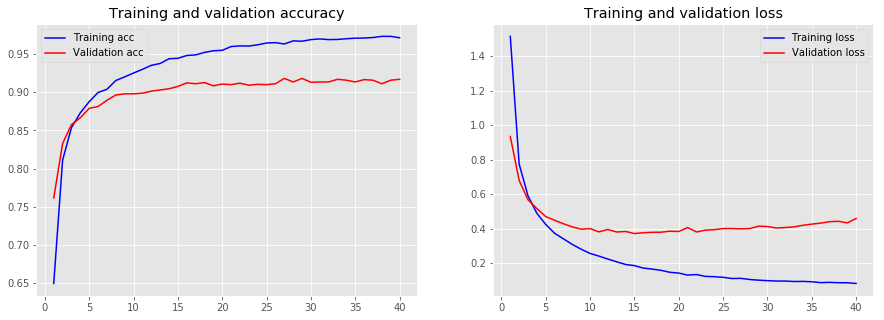

In [10]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
nn_model.plot_history(history, figsize=(15,5))

In [11]:
y_pred = model.predict(X_test)
y_pred_decode = pd.DataFrame(y_pred).idxmax(axis=1)
y_pred_decode = lb_make.inverse_transform(y_pred_decode)
y_val_decode = np.argmax(y_test, axis=1)
y_val_decode = lb_make.inverse_transform(y_val_decode)
print(classification_report(y_val_decode, y_pred_decode))

                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       0.94      0.94      0.94        33
                           Expenses::Business Vehicle::Fuel       0.82      0.98      0.89        90
            Expenses::Business Vehicle::Maintenance & Tyres       0.91      0.91      0.91        11
                Expenses::Business Vehicle::Parking & Tolls       0.94      0.97      0.95        61
             Expenses::Business Vehicle::Registration & Wof       0.00      0.00      0.00         3
     Expenses::Charities & Donations::Charities & Donations       0.75      0.75      0.75         4
                   Expenses::Commercial Office::Office Rent       1.00      1.00      1.00         2
          Expenses::General Business::Advertising/Marketing       0.80      1.00      0.89         4
                      Expenses::General Business::Bank Fees       0.99      1.00      0.99

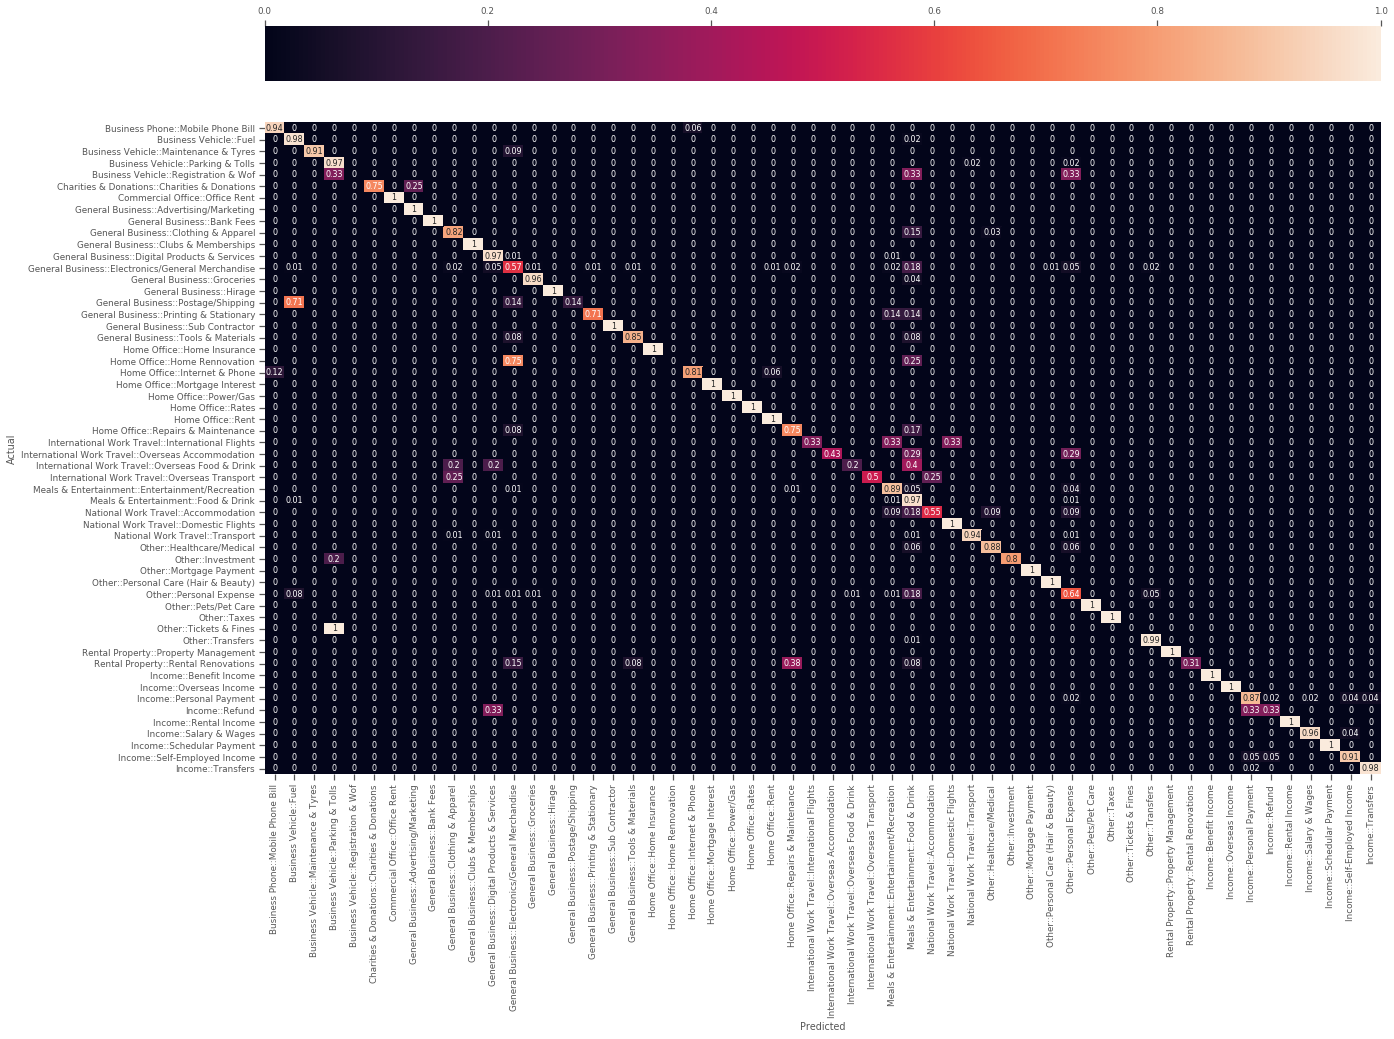

In [12]:
ml_models.show_confusion_matrix(y_val_decode, y_pred_decode, True)

In [15]:
cv_result = nn_model.evaluate_cv_model(np.array(X), y, np.array(df['label']), label_encoder=lb_make , cv=5, epochs=40, batch_size=10) 

===== Cross validation : CV= 5
accuracy: 0.922132719601074
precision: 0.8697609616616732
recall:    0.7806802612726731
f1 score:  0.8031605482855363
--------------------------------------------------
accuracy: 0.9232845026985351
precision: 0.9054644170317436
recall:    0.8223416535924061
f1 score:  0.8410060710254056
--------------------------------------------------
accuracy: 0.9148277197057685
precision: 0.9078459693170117
recall:    0.811666075140182
f1 score:  0.8357373529912268
--------------------------------------------------
accuracy: 0.927046953822274
precision: 0.9052006086180059
recall:    0.8312373601476926
f1 score:  0.8548043004557874
--------------------------------------------------
accuracy: 0.9175459163735834
precision: 0.8817658756720009
recall:    0.8167102551669994
f1 score:  0.8305783629859269
--------------------------------------------------
===== Avg F1-Score : 0.833


In [16]:
cv_result_mean = pd.DataFrame(cv_result.mean()).T
cv_result_mean['Model'] = 'NeuralNetwork'
cv_result_mean.to_csv(cf.EXPORT_PATH + 'model_results/nn.csv', index=False)
cv_result_mean

,Accuracy,Precision,Recall,F1-score,Model
0,0.920968,0.894008,0.812527,0.833057,NeuralNetwork


--------------------------------------------------------------------------------------------------------------------------------

# Benchmark

100 ...

W0715 15:50:39.681755 140405255796544 deprecation_wrapper.py:119] From /opt/anaconda/envs/Python3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 15:50:39.694578 140405255796544 deprecation_wrapper.py:119] From /opt/anaconda/envs/Python3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 15:50:39.696701 140405255796544 deprecation_wrapper.py:119] From /opt/anaconda/envs/Python3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 15:50:39.708656 140405255796544 deprecation_wrapper.py:119] From /opt/anaconda/envs/Python3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.com

200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !


,model,score,score_type,train_size
0,NeuralNetwork,0.960591,train,100
1,NeuralNetwork,0.193932,test,100
2,NeuralNetwork,0.988561,train,200
3,NeuralNetwork,0.321867,test,200
4,NeuralNetwork,0.968449,train,400


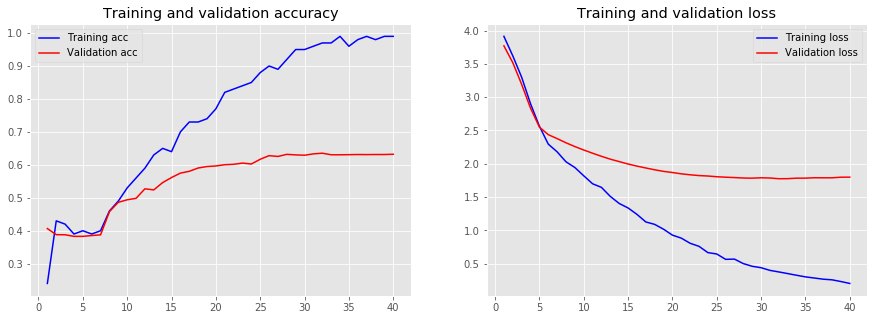

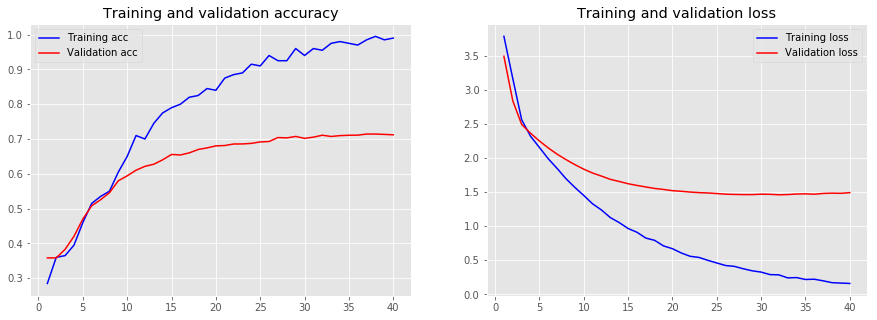

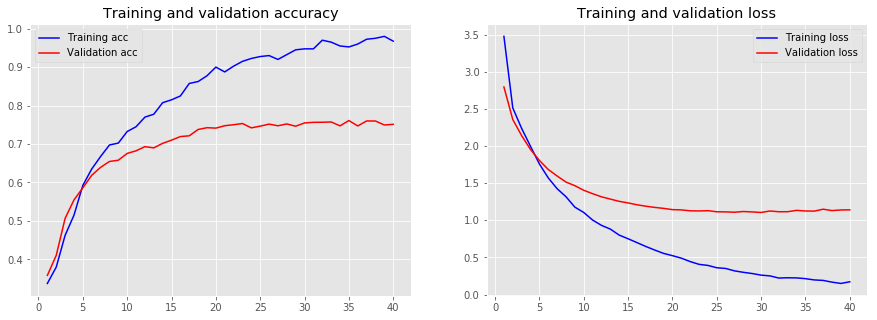

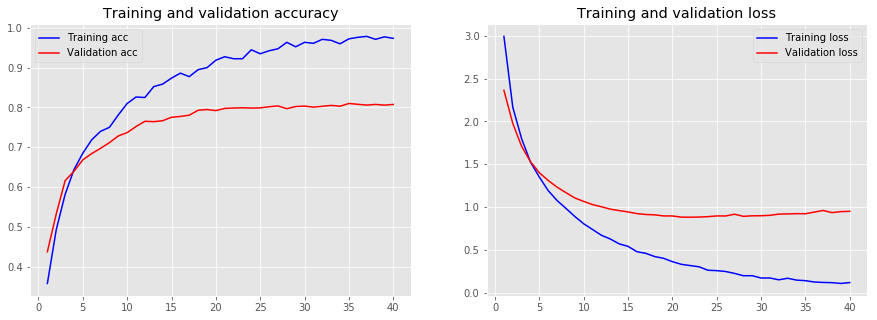

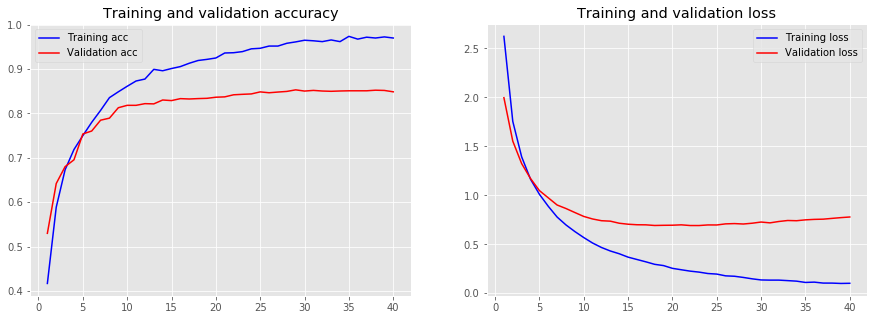

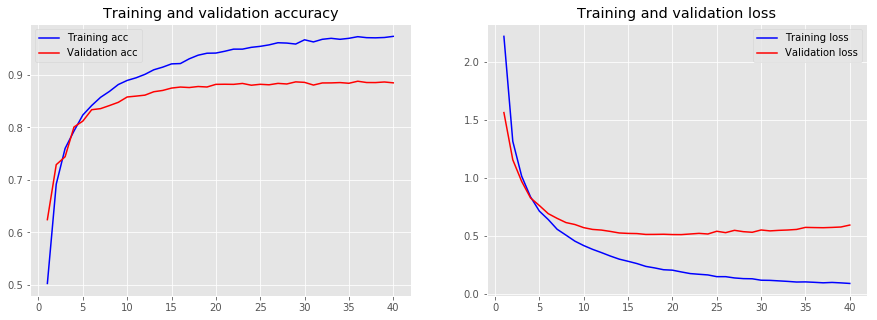

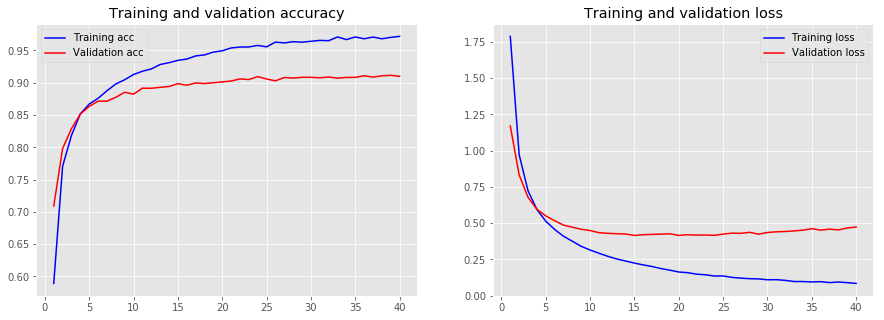

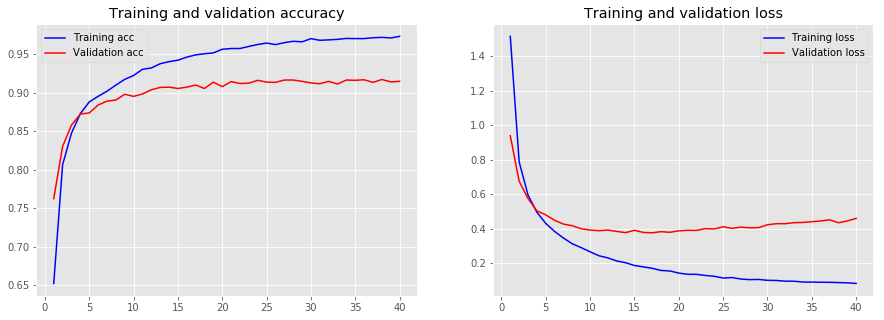

In [11]:
train_sizes = [100 , 200, 400, 800, 1600, 3200, 6400, 10000]
# Benchmark Neural Network for different training sizes
all_results = []
val_epoch_results = []
name = 'NeuralNetwork'
for n in train_sizes:
    print(n, '...', end='')
    train_scores, test_scores, val_acc = nn_model.benchmark_nn_train_size(np.array(X), np.array(y), n)
    all_results.append({'model': name, 'score_type' : 'train', 'score': train_scores, 'train_size': n})
    all_results.append({'model': name, 'score_type' : 'test', 'score': test_scores, 'train_size': n})
    val_epoch_results.append(pd.DataFrame({'train_size': n, 'epoch': range(1, len(val_acc)+1), 'val_acc' : val_acc}))
print('done !')
all_results = pd.DataFrame(all_results)
all_results.head()

In [12]:
# export results
all_results['model'] = 'NeuralNetwork'
all_results.to_csv(cf.EXPORT_PATH+ 'benchmark_nn.csv', index=False)

## Impact of the Training set size on model performance

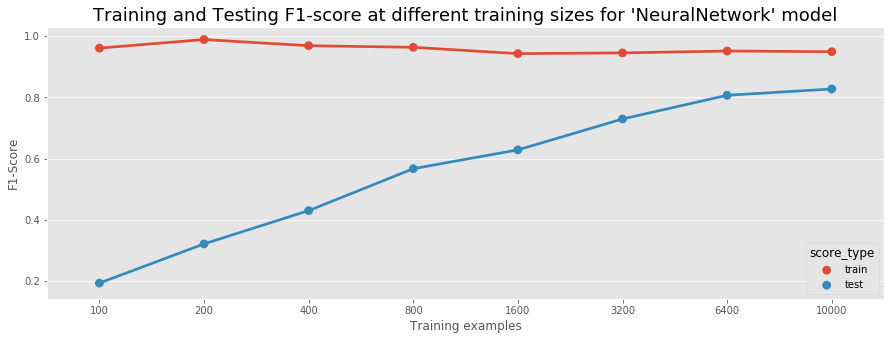

In [13]:
ml_models.plot_benchmark_train_test_score(all_results,'NeuralNetwork')
